# Sparkify Project Workspace - Exploratory Data Analysis
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## 1- Import Needed Libraries

In [2]:
# import libraries
from pyspark.sql import SparkSession

In [3]:
# create a Spark session

from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType, StringType, LongType,TimestampType
from pyspark.sql.functions import regexp_replace, col
import pyspark.sql.functions as sf
import pyspark.sql.types as st
import pyspark.sql.functions as F
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import datetime
from pyspark.sql.functions import from_utc_timestamp, from_unixtime


from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

sns.set_style('whitegrid')
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, VectorAssembler


In [4]:

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [5]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [6]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# 2- Needed User Defined 

We will use these functions to able to simplify our codes

In [7]:
# create a Spark session
def get_spark_session(master,appName):
    spark = SparkSession.builder.master(master).appName(appName).getOrCreate()
    return spark

In [8]:
def load_dataset(filename):
    df_temp = spark.read.json(filename)
    return df_temp

we will clean and transform some features to understand and manipulate easily.
we extract timestamp information from "ts" column
we extract year, month, day, hour informations from timestamp column
we manipulated location field
dropped if userId is null
We defined churn information as if page is in Cancellation Confirmation,Cancel

we manipulated userAgent column


In [9]:
def feature_engineering_phase_1(df_local):
    df_local = df_local.withColumn('transaction_timestamp', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df_local = df_local.withColumn('registration_timestamp', from_unixtime(col('registration').cast(LongType())/1000).cast(TimestampType()))
    df_local = df_local.withColumn('year', F.col('transaction_timestamp').cast('string').substr(1, 4).cast('int')) 
    df_local = df_local.withColumn('month', F.col('transaction_timestamp').cast('string').substr(6, 2).cast('int'))
    df_local = df_local.withColumn('day', F.col('transaction_timestamp').cast('string').substr(9, 2).cast('int'))
    df_local = df_local.withColumn('hour', F.col('transaction_timestamp').cast('string').substr(12, 2).cast('int'))
    df_local = df_local.withColumn('location', split(col('location'),',').getItem(1))
    #states = set([state[1].strip() for state in [x.split(',') for x in df_local.location.unique()]])
    #states = set([state[1].strip() for state in [x.split(',') for x in np.array(df_local.select('location').distinct().toPandas()['location'].tolist())]])    
    # Define a user defined function
    #state = udf(lambda x: x.split(',')[1].strip())
    #df_local = df_local.withColumn("location", state(df.location))
    df_local = df_local.filter(df_local.userId != "")
    df_local = df_local.filter(col('userId').isNotNull())
    df_local = df_local.dropna(how = "any", subset = ["userId", "sessionId"])
    df_local = df_local.withColumn('churn_flag',F.when((col('page').isin(['Cancellation Confirmation','Cancel'])),1 ).otherwise(0))
    return df_local

def feature_engineering_phase_2(df_local):
    ex = '\(([^\)]*)\)'
    userAgents = [x for x  in np.array(df_local.select('userAgent').distinct().toPandas()['userAgent'].tolist())] 
    mapping = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1', 'X11': 'Linux'}
    os_specific = udf(lambda x: mapping[re.findall(ex, x)[0].split(';')[0].capitalize()])
    df_local = df_local.withColumn("os", os_specific(df_local.userAgent).cast('string'))
    df_local = df_local.withColumn('age', F.datediff(df.transaction_timestamp, df.registration_timestamp).alias('age').cast(IntegerType()))
    df_local = df_local.drop('userAgent')
    df_local = df_local.drop('registration')
    #for field in df_local.schema.fields:
    #    if field.dataType==StringType():
    #        df_local = df_local.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    df_level = df_local.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('last_level'))
    df_status = df_local.orderBy('ts', ascending=False).groupBy('userId').agg(first('status').cast('int').alias('last_status'))
    df_local = df_local.join(df_level, on='userId') 
    df_local = df_local.join(df_status, on='userId') 
    df_local = df_local.drop('level')
    df_local = df_local.drop('status')
    df_local = df_local.drop('length')
    return df_local

# 3- Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [10]:
spark   = get_spark_session("local","Udacity - Sparkify - Exploratory Data Analysis")
df =load_dataset('mini_sparkify_event_data.json')
#df = df_full.limit(1000)

In [11]:
print('before cleaning {}'.format(df.count()))
df = feature_engineering_phase_1(df)
print('after cleaning {}'.format(df.count()))
df = feature_engineering_phase_2(df)

before cleaning 286500
after cleaning 278154


Now we can use cleaned transformed dataset for Exploratory data analysis and data visualization

In [12]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)
 |-- registration_timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- churn_flag: integer (nullable = false)
 |-- os: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- last_level: string (nullable = true)
 |-- last_status: integer (nullable = true)



In [13]:
df.createOrReplaceTempView("tbl")

# 4- Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
df.limit(10).toPandas()

,userId,artist,auth,firstName,gender,itemInSession,lastName,location,method,page,sessionId,song,ts,transaction_timestamp,registration_timestamp,year,month,day,hour,churn_flag,os,age,last_level,last_status
0,100010,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,CT,PUT,NextSong,31,Captain Tyin Knots VS Mr Walkway (No Way),1539003534000,2018-10-08 12:58:54,2018-09-27 02:45:40,2018,10,8,12,0,iPhone,11,free,307
1,100010,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,CT,PUT,NextSong,31,Beautiful_ Beautiful (Album),1539003736000,2018-10-08 13:02:16,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
2,100010,Brutha,Logged In,Darianna,F,2,Carpenter,CT,PUT,NextSong,31,She's Gone,1539003932000,2018-10-08 13:05:32,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
3,100010,None,Logged In,Darianna,F,3,Carpenter,CT,PUT,Thumbs Up,31,None,1539003933000,2018-10-08 13:05:33,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
4,100010,Josh Ritter,Logged In,Darianna,F,4,Carpenter,CT,PUT,NextSong,31,Folk Bloodbath,1539004195000,2018-10-08 13:09:55,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
5,100010,LMFAO,Logged In,Darianna,F,5,Carpenter,CT,PUT,NextSong,31,Yes,1539004511000,2018-10-08 13:15:11,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
6,100010,OneRepublic,Logged In,Darianna,F,6,Carpenter,CT,PUT,NextSong,31,Secrets,1539004694000,2018-10-08 13:18:14,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
7,100010,Dwight Yoakam,Logged In,Darianna,F,7,Carpenter,CT,PUT,NextSong,31,You're The One,1539004918000,2018-10-08 13:21:58,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
8,100010,None,Logged In,Darianna,F,8,Carpenter,CT,GET,Roll Advert,31,None,1539004961000,2018-10-08 13:22:41,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307
9,100010,The Chordettes,Logged In,Darianna,F,9,Carpenter,CT,PUT,NextSong,31,Mr Sandman,1539005157000,2018-10-08 13:25:57,2018-09-27 02:45:40,2018,10,8,13,0,iPhone,11,free,307


In [15]:
churned = spark.sql("SELECT distinct userId from tbl where churn_flag=1")
churned.createOrReplaceTempView("churned")

there are 278K row in dataset

In [62]:
df.count()

278154

In [16]:
df.filter(df.userId== "").count()

0

Lets check if there is any null column in dataset

In [17]:
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,userId,artist,auth,firstName,gender,itemInSession,lastName,location,method,page,sessionId,song,ts,transaction_timestamp,registration_timestamp,year,month,day,hour,churn_flag,os,age,last_level,last_status
0,0,50046,0,0,0,0,0,0,0,0,0,50046,0,0,0,0,0,0,0,0,0,0,0,0


how many distinct userId exists in dataset ?

In [64]:
spark.sql('''SELECT COUNT(distinct userId) from tbl''').toPandas()

,count(DISTINCT userId)
0,225


there are 52 churned customers in dataset

In [65]:
spark.sql('''SELECT COUNT(*) from churned''').toPandas()

,count(1)
0,52


how many distinct auth value exists in dataset?

In [66]:
spark.sql('''SELECT distinct auth from tbl''').toPandas()

,auth
0,Cancelled
1,Logged In


how many distinct os value exists in dataset?

In [67]:
spark.sql('''SELECT COUNT(distinct os) from tbl''').toPandas()

,count(DISTINCT os)
0,9


operating system and userId count distribution

In [22]:
spark.sql('''select * from (SELECT os,COUNT(distinct userId) from tbl group by os ORDER BY COUNT(distinct userId) desc) limit 20''').toPandas()

,os,count(DISTINCT userId)
0,MacOS,86
1,Windows 7,85
2,Windows 8.1,16
3,iPhone,13
4,Linux,12
5,Windows XP,5
6,Windows 8.0,4
7,iPad,3
8,Windows Vista,1


how many distinct artist value exists in dataset?

In [68]:
spark.sql('''SELECT COUNT(distinct artist) from tbl''').toPandas()

,count(DISTINCT artist)
0,17655


show the top 20 artist in dataset

In [24]:
spark.sql('''select * from (SELECT artist,COUNT(distinct userId) from tbl group by artist ORDER BY COUNT(distinct userId) desc) limit 20''').toPandas()

,artist,count(DISTINCT userId)
0,None,224
1,Kings Of Leon,199
2,Dwight Yoakam,189
3,Coldplay,189
4,Florence + The Machine,187
5,The Black Keys,179
6,BjÃÂ¶rk,179
7,Justin Bieber,177
8,Taylor Swift,173
9,Jack Johnson,173


there are 58K distinct song in dataset 

In [69]:
spark.sql('''SELECT COUNT(distinct song) from tbl''').toPandas()

,count(DISTINCT song)
0,58480


there are 19 distinct page in dataset

In [70]:
spark.sql('''SELECT COUNT(distinct page) from tbl''').toPandas()

,count(DISTINCT page)
0,19


get minimum and maximum registration timestamps

In [27]:
spark.sql('''SELECT min(registration_timestamp), max(registration_timestamp) from tbl''').show()

+---------------------------+---------------------------+
|min(registration_timestamp)|max(registration_timestamp)|
+---------------------------+---------------------------+
|        2018-03-18 13:44:35|        2018-11-26 15:49:14|
+---------------------------+---------------------------+



get minimum and maximum registration timestamps

In [28]:
df.agg(F.min('registration_timestamp'), F.max('registration_timestamp')).show()

+---------------------------+---------------------------+
|min(registration_timestamp)|max(registration_timestamp)|
+---------------------------+---------------------------+
|        2018-03-18 13:44:35|        2018-11-26 15:49:14|
+---------------------------+---------------------------+



get minimum and maximum transaction timestamps

In [29]:
spark.sql('''SELECT min(transaction_timestamp), max(transaction_timestamp) from tbl''').show()

+--------------------------+--------------------------+
|min(transaction_timestamp)|max(transaction_timestamp)|
+--------------------------+--------------------------+
|       2018-10-01 00:01:57|       2018-12-03 01:11:16|
+--------------------------+--------------------------+



get minimum and maximum transaction timestamps

In [30]:
df.agg(F.min('transaction_timestamp'), F.max('transaction_timestamp')).show()

+--------------------------+--------------------------+
|min(transaction_timestamp)|max(transaction_timestamp)|
+--------------------------+--------------------------+
|       2018-10-01 00:01:57|       2018-12-03 01:11:16|
+--------------------------+--------------------------+



get min, max, avg age of the users for all users

In [31]:
spark.sql('''SELECT min(age),max(age),avg(age) from tbl''').show()

+--------+--------+-----------------+
|min(age)|max(age)|         avg(age)|
+--------+--------+-----------------+
|      -2|     256|64.77642241348317|
+--------+--------+-----------------+



get min, max, avg age of the users for only churned users

In [32]:
spark.sql('''SELECT min(age),max(age),avg(age) from tbl WHERE churn_flag=1''').show()

+--------+--------+-----------------+
|min(age)|max(age)|         avg(age)|
+--------+--------+-----------------+
|       5|     188|57.35576923076923|
+--------+--------+-----------------+



show the churned counts by months

In [33]:
spark.sql('''SELECT year,month,count(distinct userId) from tbl where churn_flag=1 GROUP BY year,month order by year,month''').show()

+----+-----+----------------------+
|year|month|count(DISTINCT userId)|
+----+-----+----------------------+
|2018|   10|                    30|
|2018|   11|                    22|
+----+-----+----------------------+



In [34]:
spark.sql('''SELECT min(age),max(age),avg(age) from tbl where churn_flag=1''').show()

+--------+--------+-----------------+
|min(age)|max(age)|         avg(age)|
+--------+--------+-----------------+
|       5|     188|57.35576923076923|
+--------+--------+-----------------+



get top 20 song

In [35]:
spark.sql('''select * from (SELECT song,count(distinct userId) from tbl group by song order by count(distinct userId) desc) limit 20 ''').toPandas()

,song,count(DISTINCT userId)
0,None,224
1,You're The One,190
2,Revelry,177
3,Undo,176
4,Sehr kosmisch,172
5,Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile),164
6,Dog Days Are Over (Radio Edit),162
7,Use Somebody,155
8,Secrets,144
9,Canada,140


look at the dataset

In [36]:
df.select(['artist', 'song', 'location', 'os']).limit(10).show(10)

+--------------------+--------------------+--------+------+
|              artist|                song|location|    os|
+--------------------+--------------------+--------+------+
|Sleeping With Sirens|Captain Tyin Knot...|      CT|iPhone|
|Francesca Battist...|Beautiful_ Beauti...|      CT|iPhone|
|              Brutha|          She's Gone|      CT|iPhone|
|                null|                null|      CT|iPhone|
|         Josh Ritter|      Folk Bloodbath|      CT|iPhone|
|               LMFAO|                 Yes|      CT|iPhone|
|         OneRepublic|             Secrets|      CT|iPhone|
|       Dwight Yoakam|      You're The One|      CT|iPhone|
|                null|                null|      CT|iPhone|
|      The Chordettes|          Mr Sandman|      CT|iPhone|
+--------------------+--------------------+--------+------+



os, user distribution

In [37]:
spark.sql('''SELECT os,count(*)  from tbl where churn_flag=1 GROUP BY os ORDER BY count(distinct userId) desc''').toPandas()

,os,count(1)
0,MacOS,38
1,Windows 7,34
2,Windows 8.1,10
3,Linux,10
4,iPhone,8
5,Windows 8.0,2
6,Windows XP,2


number of churned user count based on each hour

In [38]:
spark.sql('''SELECT hour,count(*)  from tbl where churn_flag=1 GROUP BY hour ORDER BY hour ASC''').toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
hour,0,1,2,3,4,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count(1),5,2,2,4,4,2,12,2,2,4,4,2,2,8,8,4,6,10,6,6,6,3


number of session count on each hour

In [39]:
spark.sql('''SELECT hour,count(sessionId)  from tbl where  GROUP BY hour ORDER BY hour ASC''').toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count(sessionId),11079,10149,10095,10126,9954,10009,9801,9801,10000,10217,10789,10779,11459,11846,12835,13936,14297,14082,13599,13366,13215,12688,12254,11778


number of distinct session count on each hour

In [40]:
spark.sql('''SELECT hour,count(distinct sessionId)  from tbl where  GROUP BY hour ORDER BY hour ASC''').toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count(DISTINCT sessionId),666,641,633,636,624,616,627,634,626,648,682,686,715,752,792,848,844,831,807,806,785,763,735,711


get distinct userID count and distinct sessionId count

In [42]:
df.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



In [43]:
spark.sql(''' SELECT COUNT(DISTINCT userId), COUNT(DISTINCT sessionId) FROM tbl''').show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



number of interacted page count

In [44]:
event_counts = df.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')
event_counts.head()

,count
page,
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277


get to 20 page

In [45]:
pages_tmp = spark.sql(''' SELECT page,COUNT(*) FROM tbl GROUP BY page ORDER BY COUNT(*) DESC''')
pages_tmp.toPandas()

,page,count(1)
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


## 5- Visualization of Features

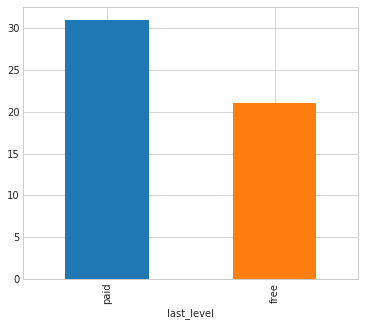

In [46]:
# Find out which level customers churn more
which_level_customer_churn_more = spark.sql('''SELECT last_level,COUNT(*) AS count FROM tbl WHERE page ='Cancellation Confirmation' GROUP BY last_level ORDER BY count DESC''').toPandas()
which_level_customer_churn_more.groupby('last_level')['count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(6,5));

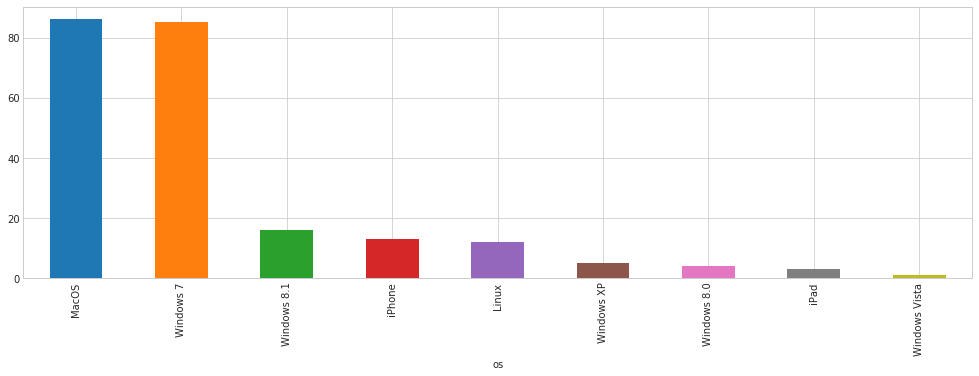

In [47]:
# Find out os userid count distribution
os = spark.sql('''SELECT os,COUNT(DISTINCT userId) AS user_counts FROM tbl GROUP BY os ORDER BY user_counts DESC''').toPandas()
os.groupby('os')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

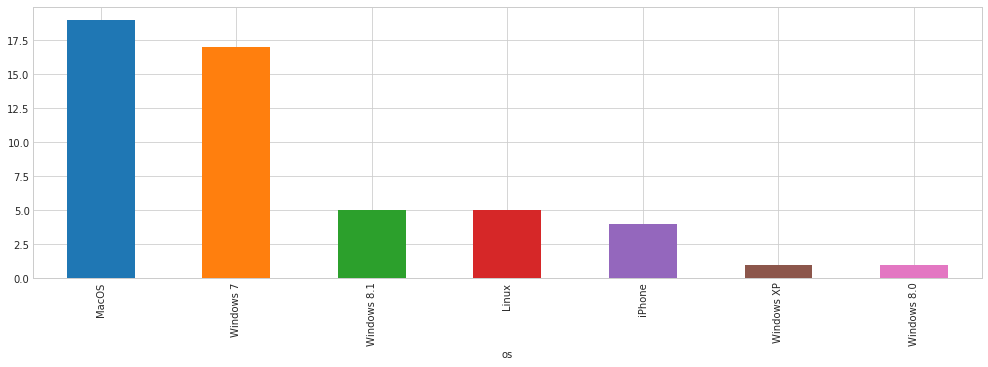

In [48]:
# Finding out which os  churn more
os = spark.sql('''SELECT os,COUNT(*) AS count FROM tbl WHERE page = 'Cancellation Confirmation' GROUP BY os ORDER BY count DESC''').toPandas()
os.groupby('os')['count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

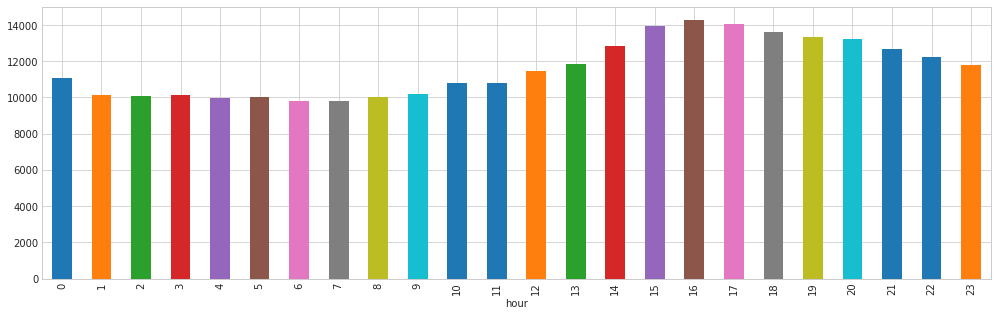

In [49]:
# session counts in each hour
cf=spark.sql('''SELECT hour,count(sessionId) as count FROM tbl GROUP BY hour ORDER BY hour ASC''').toPandas()
cf.groupby('hour')['count'].sum().plot(kind='bar',figsize=(17,5));

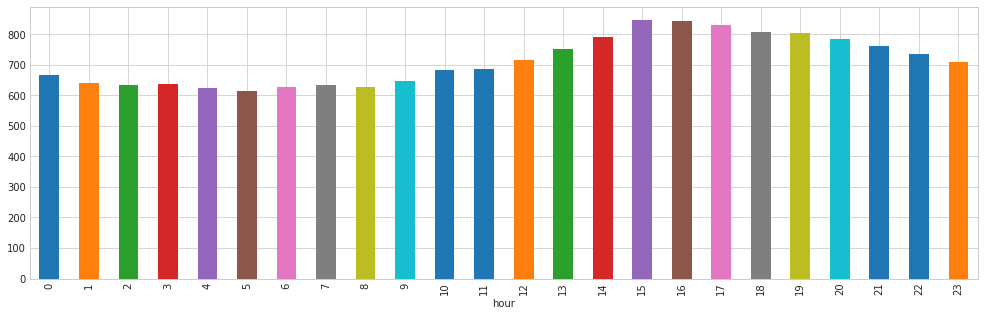

In [50]:
# distinct session counts in each hour
cf=spark.sql('''SELECT hour,count(distinct sessionId) as count FROM tbl GROUP BY hour ORDER BY hour ASC''').toPandas()
cf.groupby('hour')['count'].sum().plot(kind='bar',figsize=(17,5));

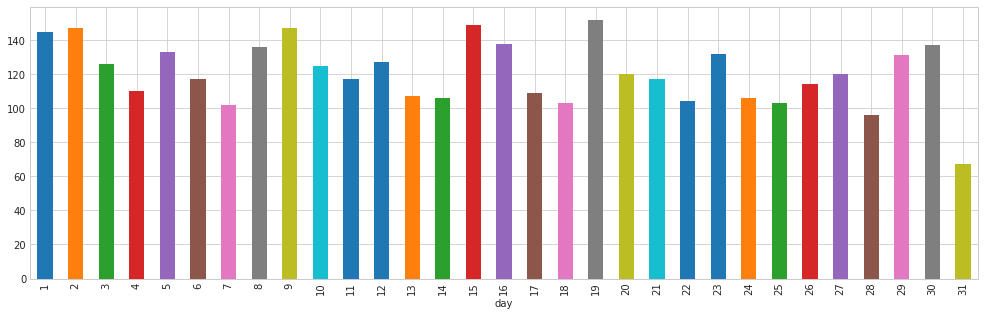

In [51]:
# distinct session counts in each day
cf=spark.sql('''SELECT day,count(distinct sessionId) as count FROM tbl GROUP BY day ORDER BY day ASC''').toPandas()
cf.groupby('day')['count'].sum().plot(kind='bar',figsize=(17,5));

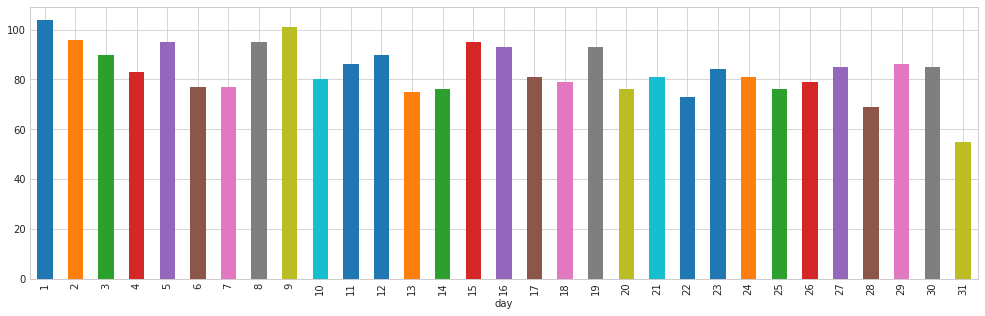

In [52]:
# distinct session counts in each day
cf=spark.sql('''SELECT day,count(distinct userId) as count FROM tbl GROUP BY day ORDER BY day ASC''').toPandas()
cf.groupby('day')['count'].sum().plot(kind='bar',figsize=(17,5));

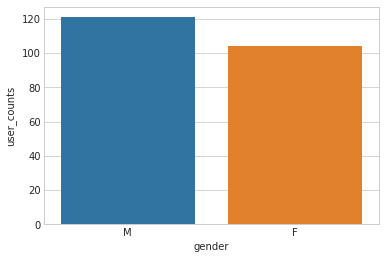

In [56]:
gender_count = spark.sql('''SELECT gender,COUNT(DISTINCT userId) AS user_counts FROM tbl GROUP BY gender ORDER BY user_counts DESC ''')
sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

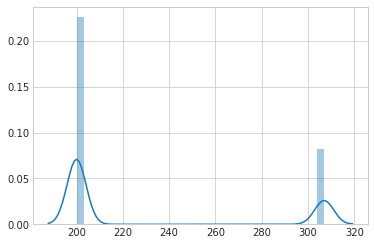

In [57]:
length_data = spark.sql('''SELECT last_status FROM tbl''')
sns.distplot(length_data.toPandas().dropna());

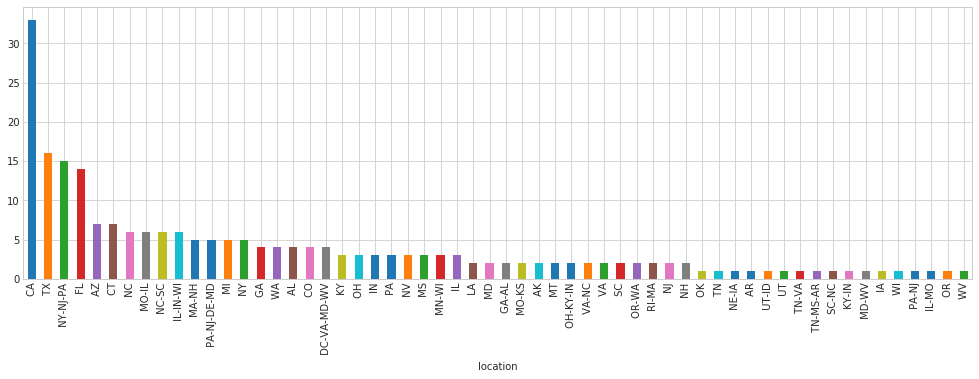

In [58]:
location_count = spark.sql('''SELECT location,COUNT(DISTINCT userId) AS user_counts FROM tbl GROUP BY location ORDER BY user_counts DESC''').toPandas()
location_count.groupby('location')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

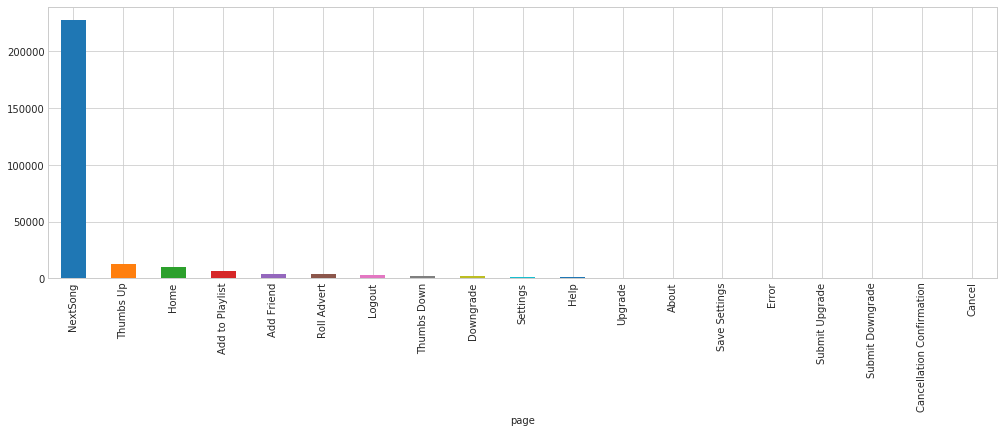

In [59]:
page=spark.sql('''SELECT page,COUNT(userId) AS user_counts FROM tbl GROUP BY page ORDER BY user_counts DESC''').toPandas()
page.groupby('page')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

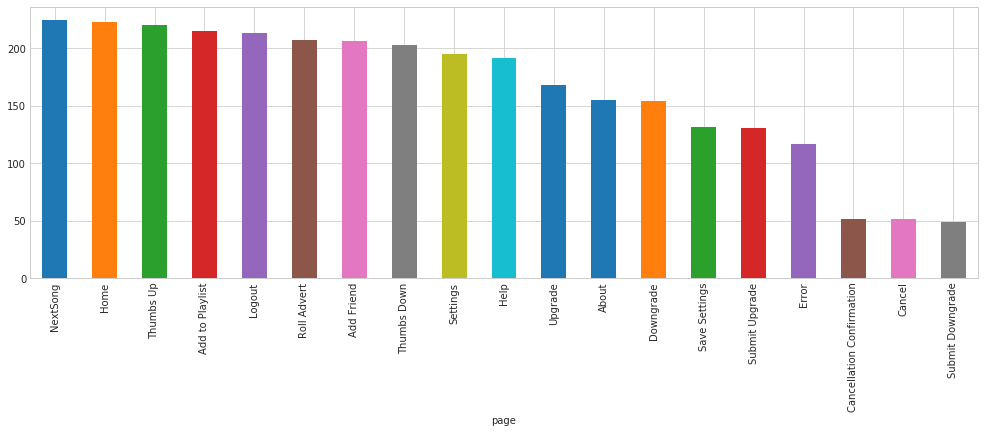

In [60]:
page_dist=spark.sql('''SELECT page,COUNT(distinct userId) AS user_counts FROM tbl GROUP BY page ORDER BY user_counts DESC''').toPandas()
page_dist.groupby('page')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

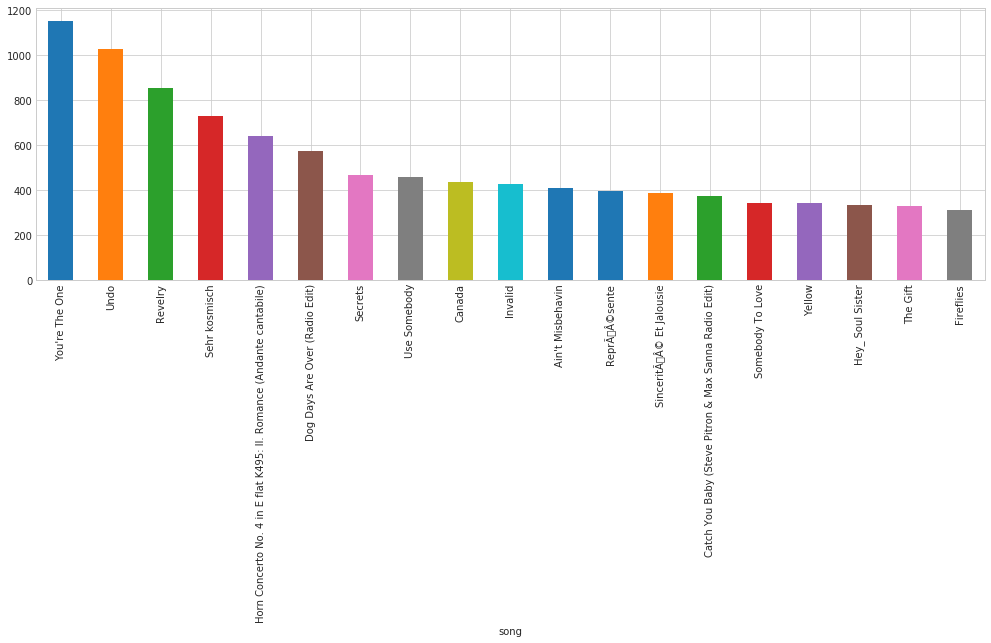

In [61]:
song=spark.sql('''select * from (SELECT song,count(userId)  AS user_counts from tbl group by song order by count(userId) desc) limit 20 ''').toPandas()
song.groupby('song')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

## Modeling and Conclusions
You can find Modelling Part in other Jupyter Note book named as "**Sparkify Project Workspace - Modelling Part**"